# Unified Evidential Training Example

To add training functionality to the probly package, we want to add a Unified Evidential Training function, that enables evidential models to be easily trained.

This notebook demonstrates how a Unified Evidential Training Function works.
It uses the `MNIST-dataset` and the `EvidentialCELoss` loss-function, as introduced by _Sensoy et al. (2018)_.
The function `unified_evidential_train()` simulates, how the routine is going to look later on.

This notebook can be divided into 5 sections:

1. Imports & Setup
2. Data Preparation
3. Model Definition
4. Unified Evidential Training Function
5. Starting Training Loop

### 1. Imports & Setup
- **torch** → building neural networks
- **torchvision** → used to convert images to tensors and normalize them
- **losses** → pre-defined loss-functions
- **models** → pre-defined models
- **unified_evidential_train** → our pre-defined unified-evidential-training function

This imports everything your Unified Evidential Training Function will also depend on:
datasets, losses, and the PyTorch core tools.
Right now we do it manually but the unified function will handle this internally later on.

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import probly.losses.evidential.torch as losses
import probly.models.evidential.torch as t
from probly.train.evidential.torch import unified_evidential_train

### 2. Data Preparation
This simulates how the function will handle datasets. It'll prepare them by e.g. converting images to tensors and normalizing pixels.

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ],
)

# In-distribution data
train_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=True,
    download=True,
    transform=transform,
)

test_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

print("MNIST loaded (ID).")

# Out-of-distribution data
ood_data = torchvision.datasets.FashionMNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

ood_loader = DataLoader(ood_data, batch_size=256, shuffle=False)

print(f"Loaded datasets with {len(train_data)} samples.")

MNIST loaded (ID).
Loaded datasets with 60000 samples.


### 3. Model Definition
This section defines a small Neural Network based on Sensoy et al. (2018), which produces alpha values. The model consists of:

- **EncoderMnist**: Flattens the input and maps it through two linear layers to a latent representation
- **EDLHead**: Takes the latent representation and outputs alpha values
- **EDLModel**: Combines the encoder and head into a complete model

Later on, we can also use models from `probly.models` if we want to. Our unified function will be able to train such a model with the corresponding evidential loss.

In [3]:
class EncoderMnist(nn.Module):  # Encoder for MNIST-dataset
    def __init__(self, latent_dim: int = 32) -> None:
        """Initialize the EncoderMnist for MNIST dataset.

        Args:
            latent_dim: Dimension of the latent space. Defaults to 32.
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the encoder.

        Args:
            x: Input tensor.

        Returns:
            torch.Tensor: Latent representation.
        """
        return self.net(x)


class EDLHead(nn.Module):
    """outputs Dirichlet concentration parameters (alpha)."""

    def __init__(self, latent_dim: int, num_classes: int = 10, hidden_dim: int = 128) -> None:
        """Initialize the EDLHead.

        Args:
            latent_dim: Dimension of the input latent vector.
            num_classes: Number of output classes. Defaults to 10.
            hidden_dim: Dimension of the hidden layer. Defaults to 128.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Forward pass to compute Dirichlet concentration parameters (alpha).

        Args:
            z: Input latent tensor.

        Returns:
            torch.Tensor: Dirichlet concentration parameters (alpha).
        """
        alpha = F.softplus(self.net(z)) + 1.0

        return alpha


class EDLModel(nn.Module):
    """Simple model for EDL classification."""

    def __init__(
        self,
        encoder: nn.Module | None = None,
        head: nn.Module | None = None,
        latent_dim: int = 32,
        num_classes: int = 10,
    ) -> None:
        """Initialize the EDLModel for evidential classification.

        Args:
            encoder: Encoder module mapping inputs to latent space.
            head: Head module for evidential output (defaults to EDLHead).
            latent_dim: Dimension of the latent space.
            num_classes: Number of output classes.
        """
        super().__init__()

        if head is None:
            head = EDLHead(latent_dim=latent_dim, num_classes=num_classes)

        self.encoder = encoder
        self.head = head

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through encoder and head.

        Args:
            x: Input tensor compatible with the encoder.

        Returns:
            Output tensor from the head module.
        """
        z = self.encoder(x)
        return self.head(z)


model = EDLModel()

### 4. Unified Evidential Training Function
In this part, we create the heart of our notebook...the Unified Evidential Train Function.
Its takes a model and a bunch of other parameters in, that the user can costumize before running.
After starting, it creates a training loop for evidential deep learning in PyTorch based on our given parameters (e.g. model, loss-function, epochs...).

In [4]:
def unified_evidential_train_showcase(model, dataloader, loss_fn, epochs=5, lr=1e-3, device="cpu") -> None:  # noqa: ANN001
    """Demonstration of a unified evidential training function."""
    model = model.to(device)  # moves the model to the correct device (GPU or CPU)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # repeats the training function for a defined number of epochs
    for epoch in range(epochs):
        model.train()  # call of train important for models like dropout
        total_loss = 0.0  # track total_loss to calculate average loss per epoch

        for x_raw, y_raw in dataloader:
            # handle both cases: distributions (CIFAR10H original) or integer labels (fallback)
            x = x_raw.to(device)

            y = torch.tensor(y_raw, device=device) if not torch.is_tensor(y_raw) else y_raw.to(device)

            optimizer.zero_grad()  # clears old gradients
            outputs = model(x)  # computes model-outputs
            loss = loss_fn(outputs, y)  # calculate the evidential loss based on given loss-function
            loss.backward()  # backpropagation
            optimizer.step()  # updates model-parameters

            total_loss += loss.item()  # add-up the loss of this epoch ontop of our total loss till then

        avg_loss = total_loss / len(dataloader)  # calculate average loss per epoch across all batches
        print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_loss:.4f}")

### 5. Starting Training Loop
In this part, we are executing the training funtion and starting the training loop, after we imported and initiated the model and the loss function. So this demonstrates the use-case.

In [5]:
enc = EncoderMnist()  # definition of own encoder
model = t.EDLModel(encoder=enc)  # model that gets trained
loss = losses.evidential_ce_loss  # initialize loss function

unified_evidential_train(
    mode="EDL",
    model=model,
    dataloader=train_loader,
    loss_fn=loss,
)  # call of uet with given parameters

Epoch [1/5] - Loss: 0.9680
Epoch [2/5] - Loss: 0.4778
Epoch [3/5] - Loss: 0.3972
Epoch [4/5] - Loss: 0.3376
Epoch [5/5] - Loss: 0.2994


### 6. Test with OOD-Data
Here we want to load the earlier defined Out-Of-Distribution-Data in our unified-evidential-training-function and compute the Uncertaintys of the two different datasets. We expect the Uncertainty for the OOD-Data to be certainly higher than the ID-Data's. 

In [6]:
def compute_alpha0_edl(model: torch.Tensor, loader: DataLoader, device: torch.device) -> torch.Tensor:
    model.eval()
    out = []

    with torch.no_grad():
        for x_raw, _ in loader:
            x = x_raw.to(device)
            alpha = model(x)
            alpha0 = alpha.sum(dim=1)
            out.append(alpha0.cpu())

    return torch.cat(out)

Mean ID α₀: 159.03125
Mean OOD α₀: 97.3193588256836


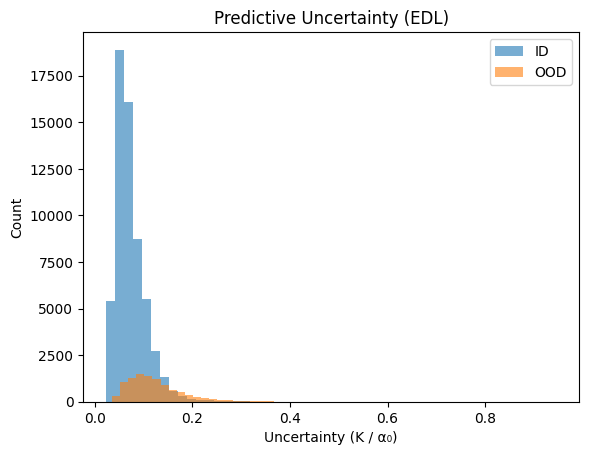

In [7]:
id_alpha0 = compute_alpha0_edl(model, train_loader, "cpu")
ood_alpha0 = compute_alpha0_edl(model, ood_loader, "cpu")

print("Mean ID α₀:", id_alpha0.mean().item())
print("Mean OOD α₀:", ood_alpha0.mean().item())


K = 10  # oder num_classes

id_unc = K / id_alpha0
ood_unc = K / ood_alpha0

plt.hist(id_unc.numpy(), bins=50, alpha=0.6, label="ID")
plt.hist(ood_unc.numpy(), bins=50, alpha=0.6, label="OOD")
plt.xlabel("Uncertainty (K / α₀)")
plt.ylabel("Count")
plt.legend()
plt.title("Predictive Uncertainty (EDL)")
plt.show()